3.1 Bonus Stage: Model with Teacher Forcing
====

To train we run the input sentence through the encoder, and keep track of every output and the latest hidden state. Then the decoder is given the

“Teacher forcing” is the concept of using the real target outputs as each next input, instead of using the decoder’s guess as the next input. Using teacher forcing causes it to converge faster but when the trained network is exploited, it may exhibit instability.

You can observe outputs of teacher-forced networks that read with coherent grammar but wander far from the correct translation - intuitively it has learned to represent the output grammar and can “pick up” the meaning once the teacher tells it the first few words, but it has not properly learned how to create the sentence from the translation in the first place.

**Note:** Because of the freedom PyTorch’s autograd gives us, we can randomly choose to use teacher forcing or not with a simple if statement. Turn `teacher_forcing_ratio up` to use more of it. 

Using the same code `train()` from above, we can easily add the teacher forcing feature to the `train_one_epoch` code like this:

In [1]:
# Imports we need.
import random
import pickle

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

use_cuda = torch.cuda.is_available()

In [2]:
import pandas as pd
from gensim.corpora.dictionary import Dictionary
from nltk import word_tokenize

# Reads the tab-delimited data using Pandas.
kopitiam = pd.read_csv('kopitiam.tsv', sep='\t')
kopitiam.head()

,Local Terms,Meaning,Source
0,Kopi O,Black Coffee with Sugar,https://daneshd.com/2010/02/28/a-rough-guide-t...
1,Kopi,Black Coffee with Condensed Milk,https://daneshd.com/2010/02/28/a-rough-guide-t...
2,Kopi C,Black Coffee with Evaporated Milk,https://daneshd.com/2010/02/28/a-rough-guide-t...
3,Kopi Kosong,Black Coffee without sugar or milk,https://daneshd.com/2010/02/28/a-rough-guide-t...
4,Kopi Gah Dai,Black Coffee with extra condensed milk,https://daneshd.com/2010/02/28/a-rough-guide-t...


In [3]:
START, START_IDX = '<s>',  0
END, END_IDX = '</s>', 1
UNK, UNK_IDX = 'UNK', 2 # Unknown words (currently not use in this model...)

singlish_sents = [START] + kopitiam['Local Terms'].apply(str.lower).apply(word_tokenize) + [END]
english_sents = [START] + kopitiam['Meaning'].apply(str.lower).apply(word_tokenize) + [END]

english_vocab = Dictionary([['<s>'], ['</s>'], ['UNK']])
english_vocab.add_documents(english_sents)

singlish_vocab = Dictionary([['<s>'], ['</s>'], ['UNK']])
singlish_vocab.add_documents(singlish_sents)

def vectorize_sent(sent, vocab):
    return vocab.doc2idx([START] + word_tokenize(sent.lower()) + [END])

def variable_from_sent(sent, vocab):
    vsent = vectorize_sent(sent, vocab)
    result = Variable(torch.LongTensor(vsent).view(-1, 1))
    return result.cuda() if use_cuda else result

# Prepare the whole training corpus.
singlish_tensors = kopitiam['Local Terms'].apply(lambda s: variable_from_sent(s, singlish_vocab))
english_tensors = kopitiam['Meaning'].apply(lambda s: variable_from_sent(s, english_vocab))

# Now, each item in `sent_pairs` is our data point. 
sent_pairs = list(zip(singlish_tensors, english_tensors))

In [4]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        # Set the no. of nodes for the hidden layer.
        self.hidden_size = hidden_size
        # Initialize the embedding layer with the 
        # - size of input (i.e. no. of words in input vocab)
        # - no. of hidden nodes in the embedding layer
        self.embedding = nn.Embedding(input_size, hidden_size)
        # Initialize the GRU with the 
        # - size of the hidden layer from the previous state
        # - size of the hidden layer from the current state
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        # Feed the input into the embedding layer.
        embedded = self.embedding(input).view(1, 1, -1)
        # Feed the embedded layer with the hidden layer to the GRU.
        # Update the output and hidden layer.
        output, hidden = self.gru(embedded, hidden)
        return output, hidden

    def initialize_hidden_states(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        return result.cuda() if use_cuda else result

    
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        # Set the no. of nodes for the hidden layer.
        self.hidden_size = hidden_size
        # Initialize the embedding layer with the 
        # - size of output (i.e. no. of words in output vocab)
        # - no. of hidden nodes in the embedding layer
        self.embedding = nn.Embedding(output_size, hidden_size)
        # Initialize the GRU with the 
        # - size of the hidden layer from the previous state
        # - size of the hidden layer from the current state
        self.gru = nn.GRU(hidden_size, hidden_size)
        # Set the output layer to output a specific symbol 
        # from the output vocabulary
        self.softmax = nn.LogSoftmax(dim=1)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        # Feed the input into the embedding layer.
        output = self.embedding(input).view(1, 1, -1)
        # Transform the embedded output with a relu function. 
        output = F.relu(output)
        # Feed the embedded layer with the hidden layer to the GRU.
        # Update the output and hidden layer.
        output, hidden = self.gru(output, hidden)
        # Take the updated output and find the most appropriate
        # output symbol. 
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initialize_hidden_states(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        return result.cuda() if use_cuda else result

In [5]:
teacher_forcing_ratio = 0.5
MAX_LENGTH = 20

def train_one_epoch(input_variable, target_variable, encoder, decoder, 
                    encoder_optimizer, decoder_optimizer, criterion):
    """
    Function to put the variables, decoder and optimizers to train per epoch.
    """
    encoder_hidden = encoder.initialize_hidden_states()

    # (Re-)Initialize the optimizers, clear all gradients. 
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    # Initialize the length of the PyTorch variables.
    input_length = input_variable.size()[0]
    target_length = target_variable.size()[0]
    encoder_outputs = Variable(torch.zeros(MAX_LENGTH, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs

    loss = 0
    
    # Iterating through each word in the input.
    for ei in range(input_length):
        # We move forward through each state.
        encoder_output, encoder_hidden = encoder(input_variable[ei], encoder_hidden)
        # And we save the encoder outputs. 
        encoder_outputs[ei] = encoder_output[0][0]


    decoder_input = Variable(torch.LongTensor([[START_IDX]]))
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input.
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(decoder_input, 
                                                     decoder_hidden)
            loss += criterion(decoder_output, target_variable[di])
            decoder_input = target_variable[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.data.topk(1)
            ni = topi[0][0]

            decoder_input = Variable(torch.LongTensor([[ni]]))
            decoder_input = decoder_input.cuda() if use_cuda else decoder_input

            loss += criterion(decoder_output, target_variable[di])
            if ni == END_IDX:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.data[0] / target_length


#########################################################
# Some Logging and Plotting Candies to Monitor Training
#########################################################

import time
import math

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)


#########################################################
# Top-level function to start the training,
# iterates across epochs.
#########################################################

def train(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)

    training_pairs = [random.choice(sent_pairs) for i in range(n_iters)]
    
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_variable = training_pair[0]
        target_variable = training_pair[1]

        loss = train_one_epoch(input_variable, target_variable, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
    
    showPlot(plot_losses)

0m 1s (- 27m 52s) (100 0%) 2.8181
0m 3s (- 24m 58s) (200 0%) 2.2449
0m 4s (- 22m 49s) (300 0%) 2.2159
0m 5s (- 22m 19s) (400 0%) 2.3359
0m 6s (- 22m 38s) (500 0%) 2.1154
0m 8s (- 22m 15s) (600 0%) 2.1644
0m 9s (- 21m 51s) (700 0%) 2.0518
0m 10s (- 21m 41s) (800 0%) 2.0338
0m 11s (- 21m 42s) (900 0%) 2.1073
0m 12s (- 21m 14s) (1000 1%) 2.0059
0m 13s (- 20m 46s) (1100 1%) 1.8731
0m 14s (- 20m 17s) (1200 1%) 1.8744
0m 15s (- 20m 1s) (1300 1%) 1.7001
0m 16s (- 19m 45s) (1400 1%) 1.7384
0m 17s (- 19m 28s) (1500 1%) 1.6712
0m 18s (- 19m 21s) (1600 1%) 1.6015
0m 20s (- 19m 17s) (1700 1%) 1.5727
0m 21s (- 19m 7s) (1800 1%) 1.6308
0m 21s (- 18m 55s) (1900 1%) 1.5080
0m 22s (- 18m 43s) (2000 2%) 1.5393
0m 23s (- 18m 34s) (2100 2%) 1.4473
0m 25s (- 18m 40s) (2200 2%) 1.5089
0m 26s (- 18m 40s) (2300 2%) 1.4943
0m 27s (- 18m 39s) (2400 2%) 1.2033
0m 28s (- 18m 50s) (2500 2%) 1.4222
0m 30s (- 18m 57s) (2600 2%) 1.2867
0m 31s (- 18m 55s) (2700 2%) 1.2439
0m 32s (- 18m 55s) (2800 2%) 1.2195
0m 34s (- 

5m 12s (- 17m 57s) (22500 22%) 0.4225
5m 14s (- 17m 57s) (22600 22%) 0.3811
5m 16s (- 17m 58s) (22700 22%) 0.4069
5m 17s (- 17m 55s) (22800 22%) 0.3352
5m 18s (- 17m 53s) (22900 22%) 0.3268
5m 20s (- 17m 52s) (23000 23%) 0.3413
5m 21s (- 17m 50s) (23100 23%) 0.4571
5m 22s (- 17m 47s) (23200 23%) 0.4021
5m 23s (- 17m 45s) (23300 23%) 0.4263
5m 24s (- 17m 42s) (23400 23%) 0.3505
5m 25s (- 17m 40s) (23500 23%) 0.5044
5m 27s (- 17m 38s) (23600 23%) 0.3902
5m 28s (- 17m 36s) (23700 23%) 0.4317
5m 29s (- 17m 35s) (23800 23%) 0.3416
5m 31s (- 17m 35s) (23900 23%) 0.3768
5m 32s (- 17m 34s) (24000 24%) 0.3539
5m 34s (- 17m 33s) (24100 24%) 0.3663
5m 36s (- 17m 33s) (24200 24%) 0.2941
5m 37s (- 17m 31s) (24300 24%) 0.4091
5m 38s (- 17m 29s) (24400 24%) 0.3252
5m 39s (- 17m 26s) (24500 24%) 0.3664
5m 40s (- 17m 24s) (24600 24%) 0.3747
5m 42s (- 17m 22s) (24700 24%) 0.2628
5m 43s (- 17m 22s) (24800 24%) 0.3680
5m 44s (- 17m 20s) (24900 24%) 0.3644
5m 45s (- 17m 17s) (25000 25%) 0.4017
5m 46s (- 17

9m 42s (- 12m 12s) (44300 44%) 0.3484
9m 44s (- 12m 12s) (44400 44%) 0.2821
9m 45s (- 12m 10s) (44500 44%) 0.3494
9m 46s (- 12m 8s) (44600 44%) 0.2833
9m 48s (- 12m 7s) (44700 44%) 0.3323
9m 49s (- 12m 5s) (44800 44%) 0.3302
9m 50s (- 12m 4s) (44900 44%) 0.3063
9m 52s (- 12m 4s) (45000 45%) 0.3391
9m 54s (- 12m 3s) (45100 45%) 0.3429
9m 55s (- 12m 1s) (45200 45%) 0.3718
9m 56s (- 12m 0s) (45300 45%) 0.2782
9m 57s (- 11m 59s) (45400 45%) 0.3062
9m 59s (- 11m 57s) (45500 45%) 0.2522
10m 0s (- 11m 56s) (45600 45%) 0.3774
10m 3s (- 11m 56s) (45700 45%) 0.3721
10m 5s (- 11m 56s) (45800 45%) 0.3182
10m 7s (- 11m 56s) (45900 45%) 0.2663
10m 9s (- 11m 55s) (46000 46%) 0.3423
10m 10s (- 11m 54s) (46100 46%) 0.3190
10m 12s (- 11m 53s) (46200 46%) 0.4070
10m 13s (- 11m 52s) (46300 46%) 0.3617
10m 15s (- 11m 51s) (46400 46%) 0.4612
10m 17s (- 11m 50s) (46500 46%) 0.3417
10m 18s (- 11m 49s) (46600 46%) 0.3487
10m 19s (- 11m 47s) (46700 46%) 0.3695
10m 21s (- 11m 46s) (46800 46%) 0.3204
10m 22s (- 1

14m 16s (- 7m 23s) (65900 65%) 0.2425
14m 17s (- 7m 21s) (66000 66%) 0.2865
14m 18s (- 7m 20s) (66100 66%) 0.3731
14m 19s (- 7m 18s) (66200 66%) 0.2976
14m 20s (- 7m 17s) (66300 66%) 0.2881
14m 21s (- 7m 15s) (66400 66%) 0.3372
14m 22s (- 7m 14s) (66500 66%) 0.3287
14m 23s (- 7m 13s) (66600 66%) 0.2598
14m 24s (- 7m 11s) (66700 66%) 0.2845
14m 25s (- 7m 10s) (66800 66%) 0.2852
14m 26s (- 7m 8s) (66900 66%) 0.3262
14m 27s (- 7m 7s) (67000 67%) 0.3240
14m 28s (- 7m 5s) (67100 67%) 0.2482
14m 29s (- 7m 4s) (67200 67%) 0.2575
14m 30s (- 7m 3s) (67300 67%) 0.3024
14m 31s (- 7m 1s) (67400 67%) 0.2233
14m 32s (- 7m 0s) (67500 67%) 0.2625
14m 33s (- 6m 58s) (67600 67%) 0.4107
14m 34s (- 6m 57s) (67700 67%) 0.2878
14m 36s (- 6m 56s) (67800 67%) 0.2464
14m 37s (- 6m 54s) (67900 67%) 0.3140
14m 38s (- 6m 53s) (68000 68%) 0.3176
14m 39s (- 6m 52s) (68100 68%) 0.3455
14m 41s (- 6m 50s) (68200 68%) 0.3327
14m 42s (- 6m 49s) (68300 68%) 0.3796
14m 43s (- 6m 48s) (68400 68%) 0.3827
14m 44s (- 6m 46s) 

18m 26s (- 2m 35s) (87700 87%) 0.3256
18m 28s (- 2m 34s) (87800 87%) 0.2709
18m 30s (- 2m 32s) (87900 87%) 0.2513
18m 31s (- 2m 31s) (88000 88%) 0.2508
18m 33s (- 2m 30s) (88100 88%) 0.3257
18m 35s (- 2m 29s) (88200 88%) 0.3528
18m 37s (- 2m 28s) (88300 88%) 0.3699
18m 39s (- 2m 26s) (88400 88%) 0.2691
18m 40s (- 2m 25s) (88500 88%) 0.2376
18m 41s (- 2m 24s) (88600 88%) 0.4081
18m 43s (- 2m 23s) (88700 88%) 0.2935
18m 44s (- 2m 21s) (88800 88%) 0.3328
18m 45s (- 2m 20s) (88900 88%) 0.2807
18m 46s (- 2m 19s) (89000 89%) 0.4582
18m 48s (- 2m 18s) (89100 89%) 0.3240
18m 49s (- 2m 16s) (89200 89%) 0.2691
18m 50s (- 2m 15s) (89300 89%) 0.3244
18m 51s (- 2m 14s) (89400 89%) 0.3249
18m 52s (- 2m 12s) (89500 89%) 0.3400
18m 53s (- 2m 11s) (89600 89%) 0.3256
18m 54s (- 2m 10s) (89700 89%) 0.3420
18m 56s (- 2m 9s) (89800 89%) 0.3524
18m 57s (- 2m 7s) (89900 89%) 0.3362
18m 58s (- 2m 6s) (90000 90%) 0.4421
18m 59s (- 2m 5s) (90100 90%) 0.3870
19m 0s (- 2m 3s) (90200 90%) 0.3513
19m 1s (- 2m 2s) (

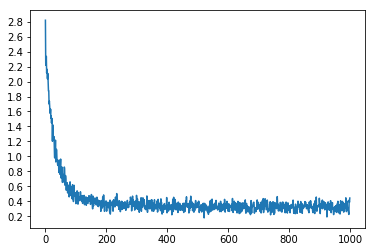

In [6]:
MAX_LENGTH = 20
batches = 100000 # In this case, the PyTorch train_per_epoch() and train() code is using batch_size=1
hidden_size = 100

my_encoder = EncoderRNN(len(singlish_vocab), hidden_size)
my_decoder = DecoderRNN(hidden_size, len(english_vocab))

if use_cuda:
    my_encoder = my_encoder.cuda()
    my_decoder = my_decoder.cuda()


# Load the pre-trained model with teacher forcing.
with open('encoder_vanilla_100_100000_0.5.pkl', 'rb') as fin:
    my_encoder = pickle.load(fin)
    
with open('decoder_vanilla_100_100000_0.5.pkl', 'rb') as fin:
    my_decoder = pickle.load(fin)

# Or train a new model; un-comment the following lines
"""
train(my_encoder, my_decoder, batches, print_every=100)
# In Python >= 3.6
with open(f'encoder_vanilla_{hidden_size}_{batches}_teacher_forcing_ratio.pkl', 'wb') as fout:
    pickle.dump(my_encoder, fout)
with open(f'decoder_vanilla_{hidden_size}_{batches}_teacher_forcing_ratio.pkl', 'wb') as fout:
    pickle.dump(my_decoder, fout)
"""

In [33]:

# Load the pre-trained model with teacher forcing.
with open('encoder_vanilla_100_100000_0.5.pkl', 'rb') as fin:
    my_encoder = pickle.load(fin)
    
with open('decoder_vanilla_100_100000_0.5.pkl', 'rb') as fin:
    my_decoder = pickle.load(fin)

In [10]:
MAX_LENGTH = 20

def translator(encoder, decoder, input_variable, max_length=MAX_LENGTH):
    # The length of the input.
    input_length = input_variable.size()[0]
    # For each sentence, initilize the hidden states with zeros.
    encoder_hidden = encoder.initialize_hidden_states()
    # Initialize the encoder outputs. 
    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs
    # Iterate through the input words.
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_variable[ei], encoder_hidden)
    # Initialize the decoder with the start symbol <s>.
    decoder_input = Variable(torch.LongTensor([[START_IDX]])) 
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input
    # Use the last encoder hidden state as the first decoder's hidden state.
    decoder_hidden = encoder_hidden
    # Keep a list of the decoded words.
    decoded_words = []
    
    # Iterate through the decoder states.
    for di in range(max_length):
        # Very similar to how the training works.
        decoder_output, decoder_hidden = decoder(decoder_input, 
                                                 decoder_hidden)
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        if ni == END_IDX:
            decoded_words.append(END_IDX)
            break
        else:
            decoded_words.append(ni)
        # Replace the new decoder input for the next state 
        # with the top guess of this state.
        decoder_input = Variable(torch.LongTensor([[ni]]))
        decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    return decoded_words

    
def translate(kopi_order):
    output_words = translator(my_encoder, my_decoder, variable_from_sent(kopi_order, singlish_vocab))
    output_sentence = [english_vocab[i] for i in output_words[1:output_words.index(1)]]
    return ' '.join(output_sentence)

In [34]:
translate('teh c')

'tea with evaporated milk and sugar'

In [35]:
translate('teh ga dai')

'hot tea with condensed milk and more sugar'

In [36]:
translate('teh c ga dai')

'hot tea with evaporated milk and more sugar'

In [37]:
translate('teh c ga dai peng')

'iced tea with evaporated milk'

In [38]:
translate('teh o siew dai')

'hot tea with lesser sugar'

In [39]:
translate('teh tiloh')

'heaviest , purest version of tea with no water added at all to the initial brew'

In [40]:
translate('tak kiu peng')

'iced milo'

In [41]:
translate('tak kiu gau peng')

'milo'

In [42]:
translate('michael jackson')

'soya bean milk mixed with grass jelly'

In [43]:
translate('michael jackson peng')

'iced strong iced coffee with'

In [44]:
translate('teh siew dai peng')

'iced tea with condensed milk'

In [45]:
translate('kopi peng gau')

'strong coffee with coffee with'

In [46]:
translate('kopi gau peng')

'strong iced coffee with condensed milk'

In [47]:
translate('kopi o gau peng')

'strong black coffee with sugar'

In [48]:
translate('kopi o gau siew dai')

'hot black coffee with more coffee powder and lesser sugar'

In [49]:
translate('kopi dinosaur gau siew dai')

'hot coffee with condensed milk and lesser coffee powder and lesser sugar'